Name: Kelly Ton

Development environment (Colab or local): Colab

# Baseline, PCA, LDA and SVM analysis

- Task:
  - Come up with and implement a baseline for this task
    - Consider what technqiues we've covered in class might be relevant. Or come up with something all on your own.
    - Include a description of your baseline to accompany the implementation and explain why this baseline makes sense for this problem.
  - Compare the performance of your simple baseline, PCA, LDA, and SVM using the Olivetti faces dataset in different evaluation scenarions

- Evaluation scenarios:
  - Use 20% of the images for training and 80% for testing
  - Use 50% of the images for training and 50% for testing
  - Use 80% of the images for training and 20% for testing
  - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
  - Plot CMC curve and confusion matrix for each combination of scenario and method
  - If hyperparameters need to be selected, pull out a reasonable held-out set from the training set.

- Discussion:
  - If you used a held-out set, how did you choose your method of held-out set selection method? If not, why was it not necessary?
    - What effect did your choice have on your final results?
  - Is there a clear difference in performance for different approaches?
  - Is there a clear difference in performance for different train/test data splits?

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [ ]:
# provided
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np

# I added
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Get the dataset

In [ ]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)


# Split the dataset

In [ ]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 5                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(200, 4096) (200, 4096)


# Visualize the splits

In [ ]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

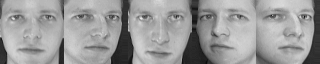

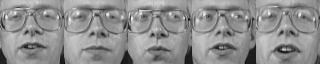

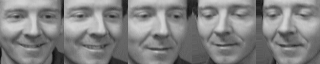

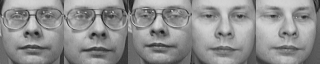

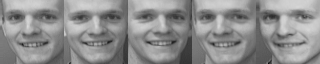

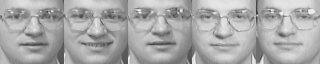

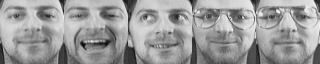

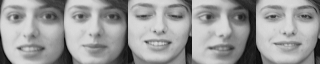

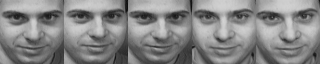

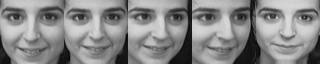

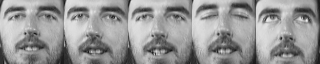

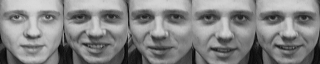

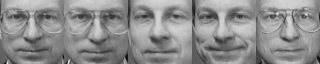

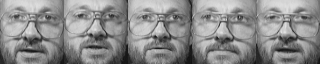

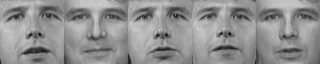

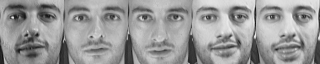

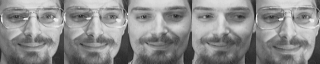

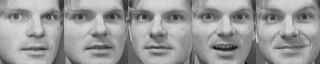

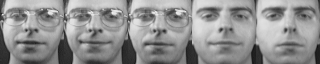

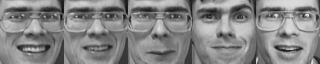

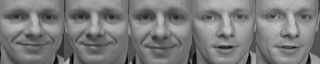

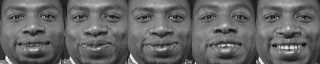

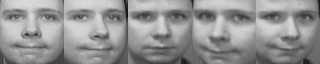

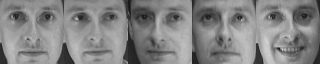

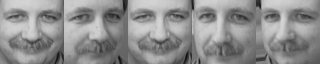

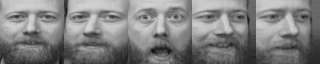

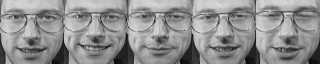

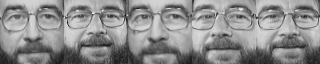

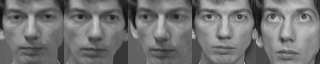

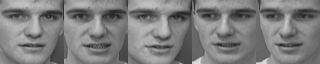

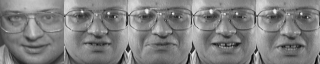

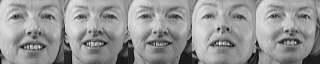

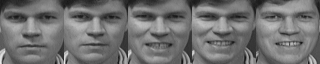

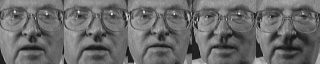

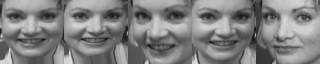

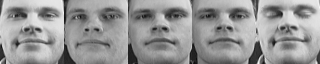

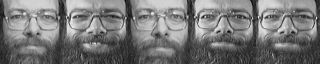

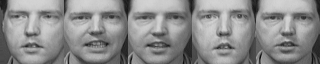

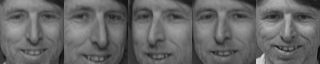

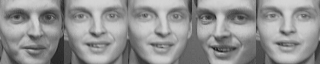

In [ ]:
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

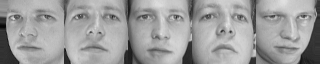

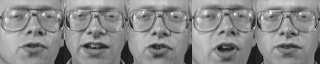

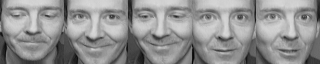

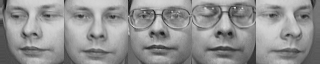

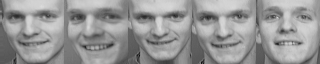

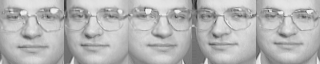

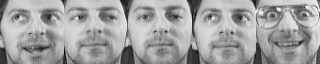

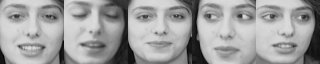

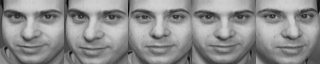

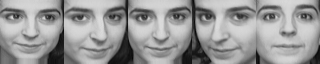

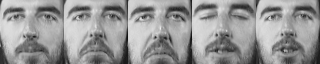

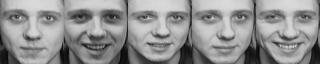

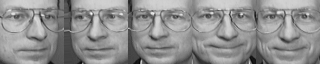

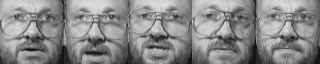

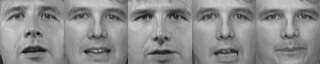

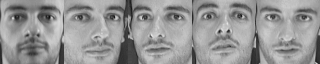

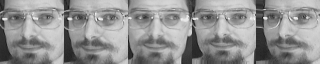

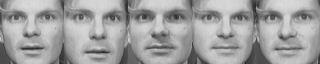

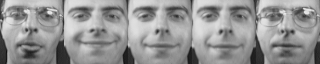

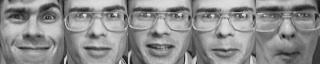

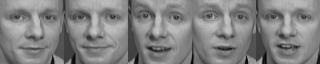

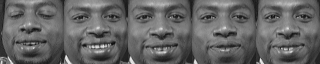

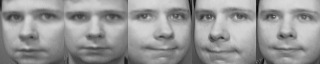

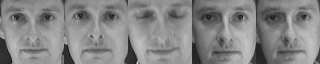

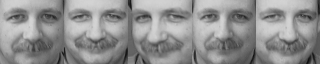

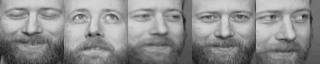

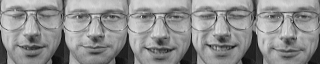

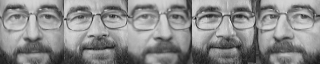

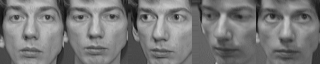

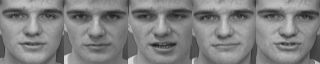

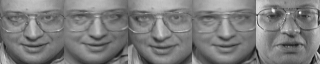

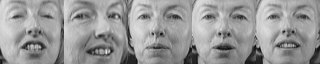

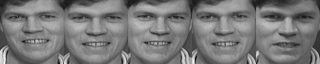

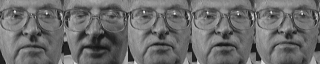

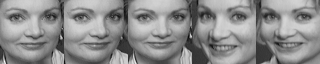

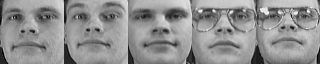

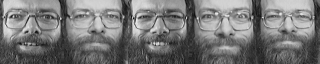

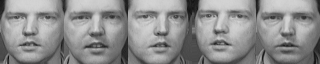

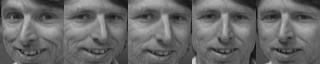

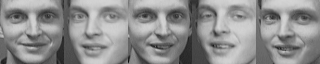

In [ ]:
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

# Implement your baseline

Here is the code for my baseline, along with an explanation of how it works and why it makes sense for this problem.

In [ ]:
# baseline
def baseline(X_train, y_train, X_test, y_test, model):
  if model is None:
    model = GaussianNB()

  # fit model on training data
  model.fit(X_train, y_train)

  # make predictions on test data
  y_prediction = model.predict(X_test)

  # calculate accuracy and return it
  confusion_mat = confusion_matrix(y_test, y_prediction)
  return accuracy_score(y_test, y_prediction), confusion_mat

In [ ]:
train_sizes = [0.2, 0.5, 0.8]  # 20%, 50%, 80% of images for training

# baseline: Gaussian Naive Bayes
naive_bayes_model = GaussianNB()
baseline_accuracy, baseline_confusion_mat = baseline(x_train, y_train, x_test, y_test, model=naive_bayes_model)
print(f"Baseline Accuracy: {baseline_accuracy:.2%}")
print("Confusion Matrix:\n", baseline_confusion_mat, "\n")

Baseline Accuracy: 72.50%
Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 ...
 [0 0 0 ... 4 0 1]
 [0 0 0 ... 0 5 0]
 [1 0 0 ... 0 0 4]] 



For my baseline, I incorporated Naive Bayes, specifically Guassian Naive Bayes. This baseline has a strong assumption that all features are independent given the label, so it can be useful for an initial baseline. Naive Bayes is a common baseline to use if it's a new task. It also allows for a simple classification model. As a result, I chose this method, as the baseline is set as the initial performance benchmark, which is why it made sense for this problem.

# Run the experiments

Here is the code I used to get the results below!

**BASELINE**

In [ ]:
def baseline_eval_scenarios(X_train, y_train, X_test, y_test, model=None):
  # check if training set is empty
  if len(X_train) == 0:
    print("This evaluation has an empty training set.")
    return

  # evaluation scenarios
  scenarios = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]

  # iterate through scenarios
  for train_ratio, test_ratio in scenarios:
    # dataset train/test split
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, train_size=train_ratio, test_size=test_ratio, stratify=y_train,
    random_state=42
    )

    print(f"\nScenario: {int(train_ratio * 100)}% training, {int(test_ratio * 100)}% testing")

    # call baseline and get accuracy and confusion matrix
    baseline_accuracy, baseline_confusion_matrix = baseline(
      x_train_split, y_train_split, X_test, y_test, model=model
    )

    # print accuracy and confusion matrix
    print(f"Baseline Accuracy: {baseline_accuracy:.2%}")
    print("Confusion Matrix for Baseline:\n", baseline_confusion_matrix)

    # CMC curve ----------------------------------------------------------------
    cmc_legend_labels = []  # for storing labels for legend

    for i in range(10, 101, 10):
      n_components_for_iteration = min(i, 40)
      pca_for_cmc = PCA(n_components=n_components_for_iteration)
      pca_for_cmc.fit(x_train_split.reshape(-1, img_height * img_width))

      gallery = pca_for_cmc.transform(x_train_split.reshape(-1, img_height * img_width))
      probe = pca_for_cmc.transform(X_test.reshape(-1, img_height * img_width))

      CMC = {}
      for j in range(len(probe)):
        genuine_dist = np.inf
        dist = 0
        for k in range(len(gallery)):
          if y_test[j] == y_train_split[k]:
            dist = np.sum((gallery[k] - probe[j]) ** 2)
          if dist < genuine_dist:
            genuine_dist = dist
        ids = set()
        for k in range(len(gallery)):
          if y_test[j] != y_train_split[k]:
            dist = np.sum((gallery[k] - probe[j]) ** 2)
            if dist < genuine_dist:
              ids.add(y_train_split[k])
        rank = 1 + len(ids)
        if rank not in CMC:
          CMC[rank] = 1
        else:
          CMC[rank] += 1

      ranks = []
      accuracies = []
      total = 0
      for j in range(1, N_IDENTITIES + 1):
        if j in CMC:
          total += CMC[j]
        ranks.append(j)
        accuracies.append(100.0 * total / len(probe))

      plt.plot(ranks, accuracies, label=str(i) + ' eigenvectors')
      cmc_legend_labels.append(str(i) + ' eigenvectors')

    # outside the loop, after all curves are plotted
    plt.legend(labels=cmc_legend_labels)
    plt.ylim(0, 100)
    plt.title("CMC Curve for Baseline")
    plt.xlabel('Rank')
    plt.ylabel('Recognition Rate (%)')
    plt.show()

    # plot confusion matrix ----------------------------------------------------
    unique_labels = np.unique(y_test)
    person_names = [f"Person {label + 1}" for label in unique_labels]

    plt.figure(figsize=(10, 8))
    sns.heatmap(baseline_confusion_matrix.T, square=True, annot=True, fmt='d', cbar=False,
       xticklabels=person_names, yticklabels=person_names)
    plt.title("Confusion Matrix for Baseline")
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()


Scenario: 20% training, 80% testing
Baseline Accuracy: 51.50%
Confusion Matrix for Baseline:
 [[1 0 0 ... 0 0 2]
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 ...
 [0 0 0 ... 4 0 1]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


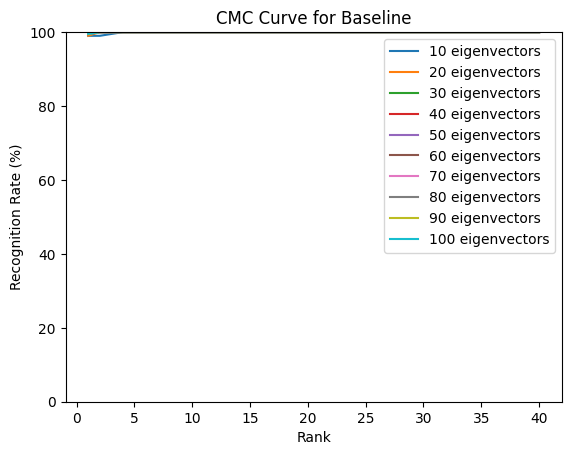

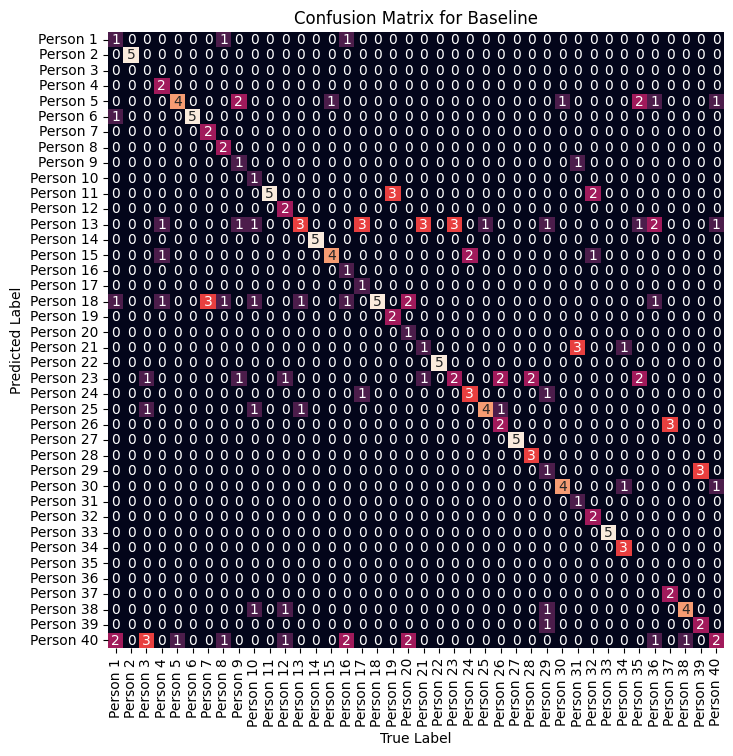


Scenario: 50% training, 50% testing
Baseline Accuracy: 9.50%
Confusion Matrix for Baseline:
 [[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]


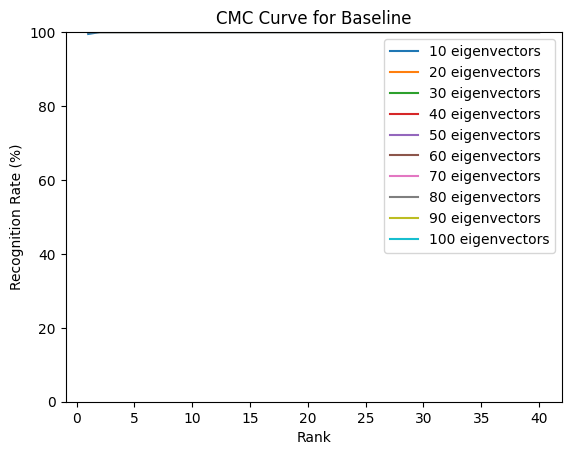

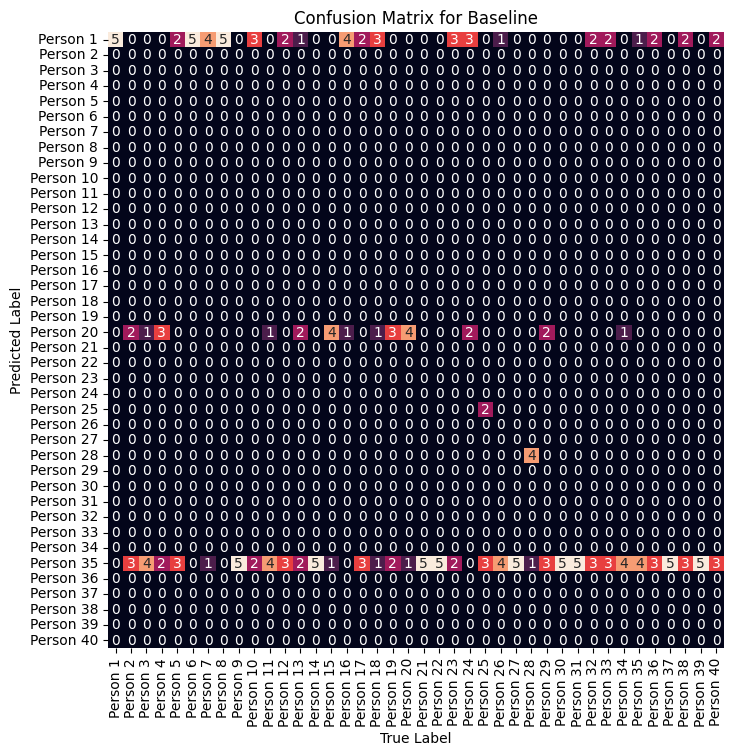


Scenario: 80% training, 20% testing
Baseline Accuracy: 55.50%
Confusion Matrix for Baseline:
 [[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]


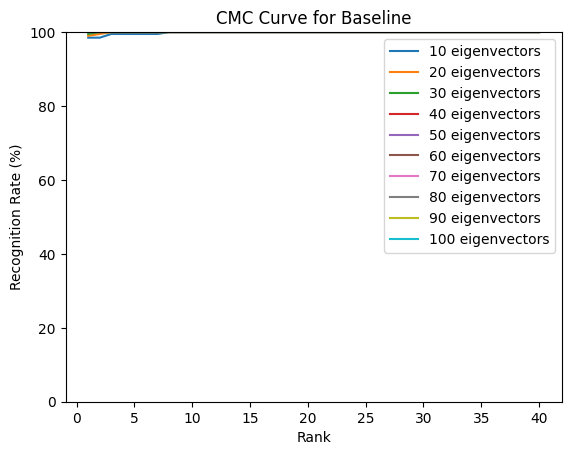

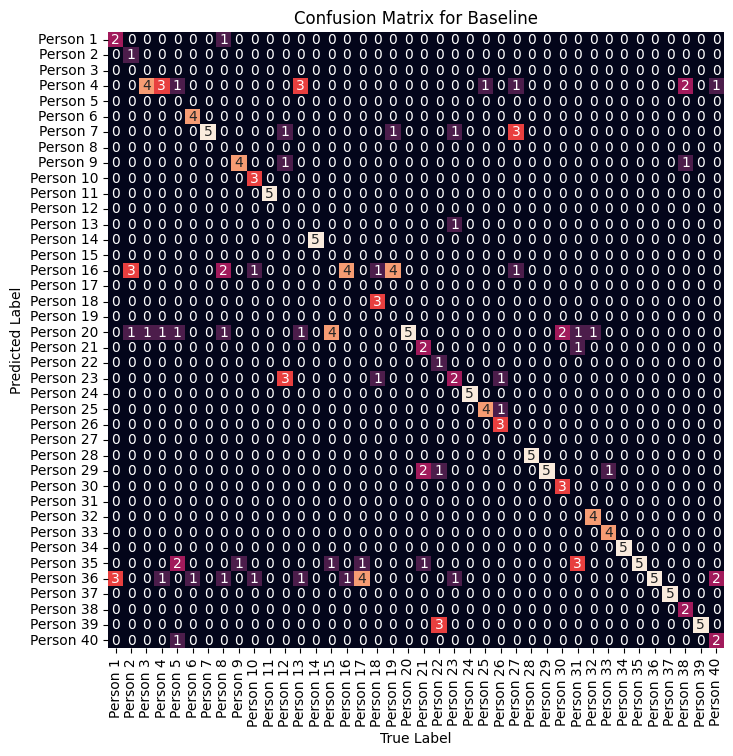

In [ ]:
naive_bayes_model = GaussianNB()
baseline_eval_scenarios(x_train, y_train, x_test, y_test, naive_bayes_model)

**PCA**

In [ ]:
# PCA
def PCA_fn(X_train, y_train, X_test, y_test):
  # apply PCA
  pca = PCA(n_components=0.95) # 95% variance gave me the highest accuracy

  # PCA transformation on training data
  pca_X_train = pca.fit_transform(X_train)

  # PCA transformation on test data
  pca_X_test = pca.transform(X_test)

  return pca_X_train, pca_X_test

In [ ]:
def pca_eval_scenarios(X_train, y_train, X_test, y_test):
  # check if training set is empty
  if len(X_train) == 0:
    print("This evaluation has an empty training set.")
    return

  # evaluation scenarios
  scenarios = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]

  # iterate through scenarios
  for train_ratio, test_ratio in scenarios:
    # dataset train/test split
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
        X_train, y_train, train_size=train_ratio, test_size=test_ratio, stratify=y_train,
        random_state=42
    )

    print(f"\nScenario: {int(train_ratio * 100)}% training, {int(test_ratio * 100)}% testing")

    # PCA
    pca_X_train, pca_X_test = PCA_fn(x_train_split, y_train_split, X_test, y_test)

    # train SVM classifier with linear kernel
    svm = SVC(kernel='linear', C=1.0)
    svm.fit(pca_X_train, y_train_split)

    # PCA predictions
    pca_y_pred = svm.predict(pca_X_test)

    # accuracy
    pca_accuracy = accuracy_score(y_test, pca_y_pred)
    print(f"PCA Accuracy: {pca_accuracy:.2%}")

    # confusion matrix
    pca_confusion_matrix = confusion_matrix(y_test, pca_y_pred)
    print("Confusion Matrix for PCA:\n", pca_confusion_matrix)

    # CMC Curve ----------------------------------------------------------------
    for i in range(10, 101, 10):
      n_components_for_iteration = min(i, 40)
      pca_for_cmc = PCA(n_components=n_components_for_iteration)
      pca_for_cmc.fit(x_train_split.reshape(-1, img_height * img_width))

      gallery = pca_for_cmc.transform(x_train_split.reshape(-1, img_height * img_width))
      probe = pca_for_cmc.transform(X_test.reshape(-1, img_height * img_width))

      CMC = {}
      for j in range(len(probe)):
        genuine_dist = np.inf
        for k in range(len(gallery)):
          if y_test[j] == y_train_split[k]:
            dist = np.sum((gallery[k] - probe[j]) ** 2)
            if dist < genuine_dist:
              genuine_dist = dist
        ids = set()
        for k in range(len(gallery)):
          if y_test[j] != y_train_split[k]:
            dist = np.sum((gallery[k] - probe[j]) ** 2)
            if dist < genuine_dist:
              ids.add(y_train_split[k])
        rank = 1 + len(ids)
        if rank not in CMC:
          CMC[rank] = 1
        else:
          CMC[rank] += 1

      ranks = []
      accuracies = []
      total = 0
      for j in range(1, N_IDENTITIES + 1):
        if j in CMC:
          total += CMC[j]
        ranks.append(j)
        accuracies.append(100.0 * total / len(probe))

      plt.plot(ranks, accuracies, label=str(i) + ' eigenvectors')

    plt.legend()
    plt.ylim(0, 100)
    plt.title("CMC Curve for PCA")
    plt.xlabel('Rank')
    plt.ylabel('Recognition Rate (%)')
    plt.show()

    unique_labels = np.unique(faces.target)

    person_names = [f"Person {label + 1}" for label in unique_labels]

    confusion_mat = confusion_matrix(y_test, pca_y_pred)

    # plot the confusion matrix ------------------------------------------------
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=person_names, yticklabels=person_names)
    plt.title("Confusion Matrix for PCA")
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()


Scenario: 20% training, 80% testing
PCA Accuracy: 48.50%
Confusion Matrix for PCA:
 [[0 0 0 ... 1 0 2]
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 ...
 [0 0 0 ... 3 0 1]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


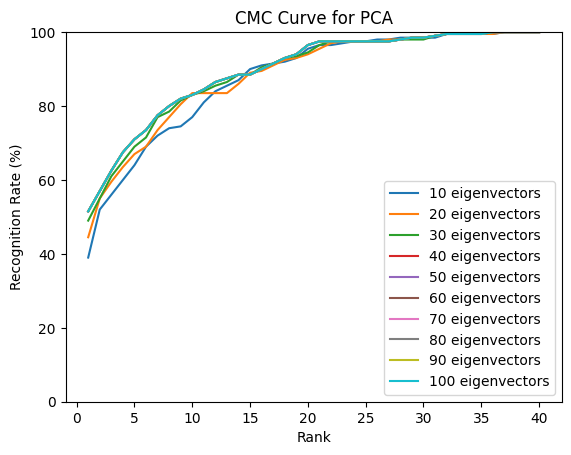

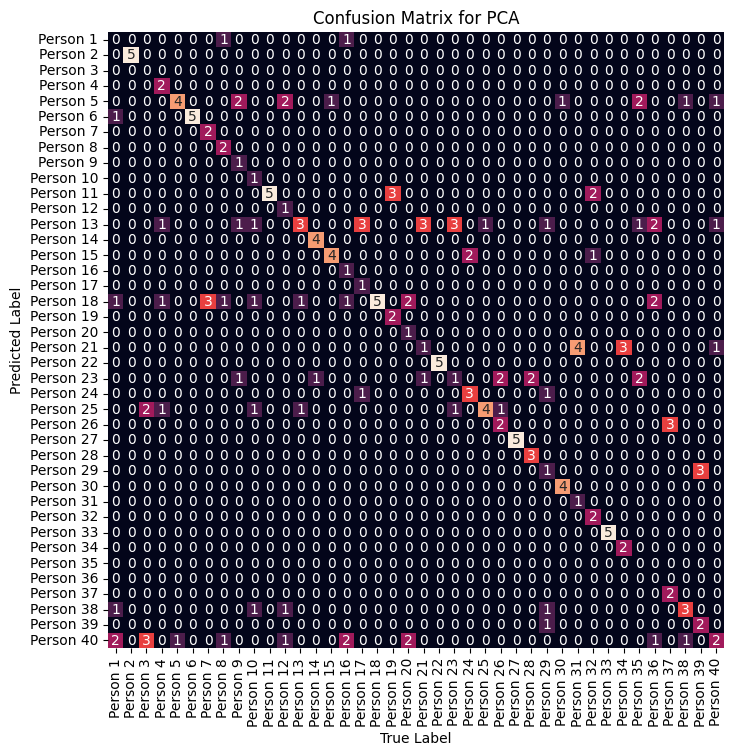


Scenario: 50% training, 50% testing
PCA Accuracy: 78.50%
Confusion Matrix for PCA:
 [[4 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 1 0 2]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [1 0 0 ... 0 0 2]]


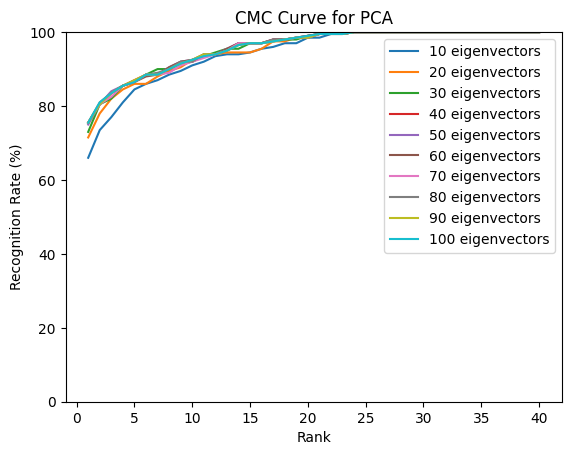

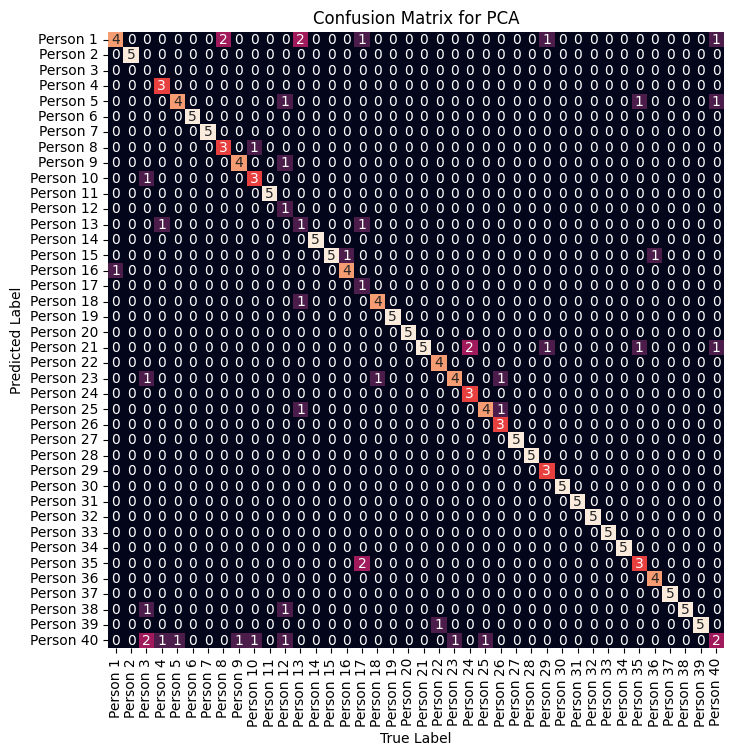


Scenario: 80% training, 20% testing
PCA Accuracy: 85.00%
Confusion Matrix for PCA:
 [[4 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 1 ... 0 0 2]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]


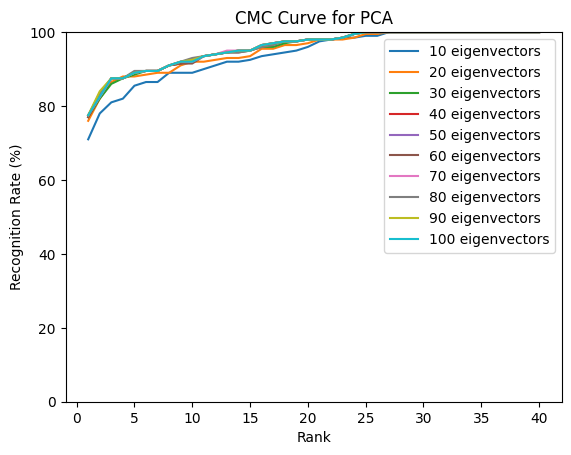

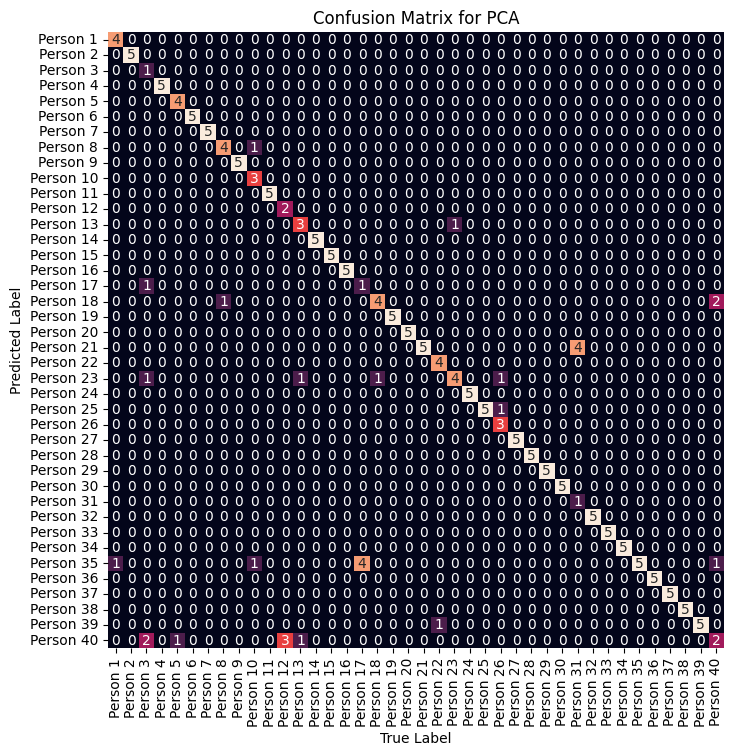

In [ ]:
pca_eval_scenarios(x_train, y_train, x_test, y_test)

**LDA**

In [ ]:
# LDA
def LDA_fn(X_train, y_train, X_test, y_test):
  # unique classes in training set
  unique_classes = np.unique(y_train)

  # compare number of training samples and unique classes
  if len(X_train) <= len(unique_classes):
    return X_train, X_test

  # instance of LDA
  lda = LDA()

  # fit LDA on training set
  lda.fit(X_train, y_train)

  # transform the data
  lda_X_train = lda.transform(X_train)
  lda_X_test = lda.transform(X_test)

  return lda_X_train, lda_X_test

In [ ]:
def lda_eval_scenarios(X_train, y_train, X_test, y_test):
  # check if training set is empty
  if len(X_train) == 0:
    print("This evaluation has an empty training set.")
    return

  # iterate through scenarios
  scenarios = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]

  for train_ratio, test_ratio in scenarios:
    # dataset train/test split
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, train_size=train_ratio, test_size=test_ratio, stratify=y_train,
    random_state=42
    )

    print(f"\nScenario: {int(train_ratio * 100)}% training, {int(test_ratio * 100)}% testing")

    # call LDA on the PCA-transformed data
    lda_X_train, lda_X_test = LDA_fn(x_train_split, y_train_split, X_test, y_test)

    # train SVM classifier on LDA-transformed data
    svm = SVC(kernel='linear', C=1.0)
    svm.fit(lda_X_train, y_train_split)

    # predictions on test set
    lda_y_pred = svm.predict(lda_X_test)

    # accuracy
    lda_accuracy = accuracy_score(y_test, lda_y_pred)
    print(f"LDA Accuracy: {lda_accuracy:.2%}")

    # confusion matrix
    lda_confusion_mat = confusion_matrix(y_test, lda_y_pred)
    print("Confusion Matrix for LDA:\n", lda_confusion_mat)

    # CMC Curve ----------------------------------------------------------------
    for i in range(10,40,10):
      lda = LDA(n_components=i)
      lda.fit(x_train.reshape(-1, img_height*img_width), y_train)

      gallery = lda.transform(x_train.reshape(-1, img_height*img_width))
      probe = lda.transform(x_test.reshape(-1, img_height*img_width))

      CMC = {}
      for j in range(len(probe)):
        genuine_dist = np.inf
        for k in range(len(gallery)):
          if y_test[j] == y_train[k]:
            dist = np.sum((gallery[k]-probe[j])**2)
            if dist < genuine_dist:
              genuine_dist = dist
        ids = set()
        for k in range(len(gallery)):
          if y_test[j] != y_train[k]:
            dist = np.sum((gallery[k]-probe[j])**2)
          if dist < genuine_dist:
            ids.add(y_train[k])
        rank=1+len(ids)
        if rank not in CMC:
          CMC[rank] = 1
        else:
          CMC[rank] += 1

      rank = []
      acc = []
      total = 0
      for j in range(1, N_IDENTITIES+1):
        if j in CMC:
          total += CMC[j]
        rank.append(j)
        acc.append(100.0*total/len(probe))

      plt.plot(rank, acc, label=str(i)+' eigenvectors')
      plt.legend()
      plt.ylim(0, 100)
      plt.title("CMC Curve for LDA")
      plt.xlabel('Rank')
      plt.ylabel('Recognition Rate (%)')
      plt.plot()

    # plot the confusion matrix ------------------------------------------------
    unique_labels = np.unique(y_test)

    person_names = [f"Person {label + 1}" for label in unique_labels]

    plt.figure(figsize=(10, 8))
    sns.heatmap(lda_confusion_mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels=person_names, yticklabels=person_names)
    plt.title("Confusion Matrix for LDA")
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()


Scenario: 20% training, 80% testing
LDA Accuracy: 51.50%
Confusion Matrix for LDA:
 [[1 0 0 ... 0 0 2]
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 ...
 [0 0 0 ... 4 0 1]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


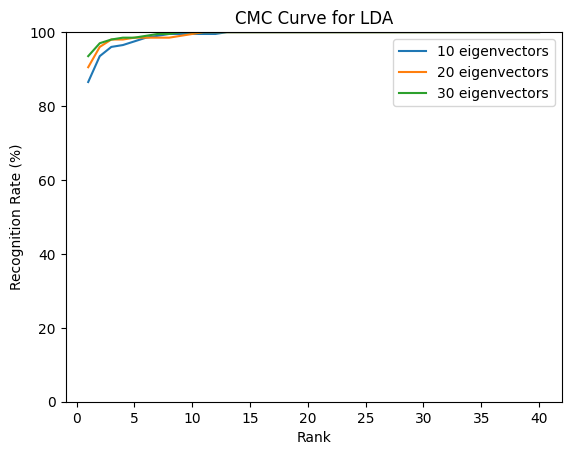

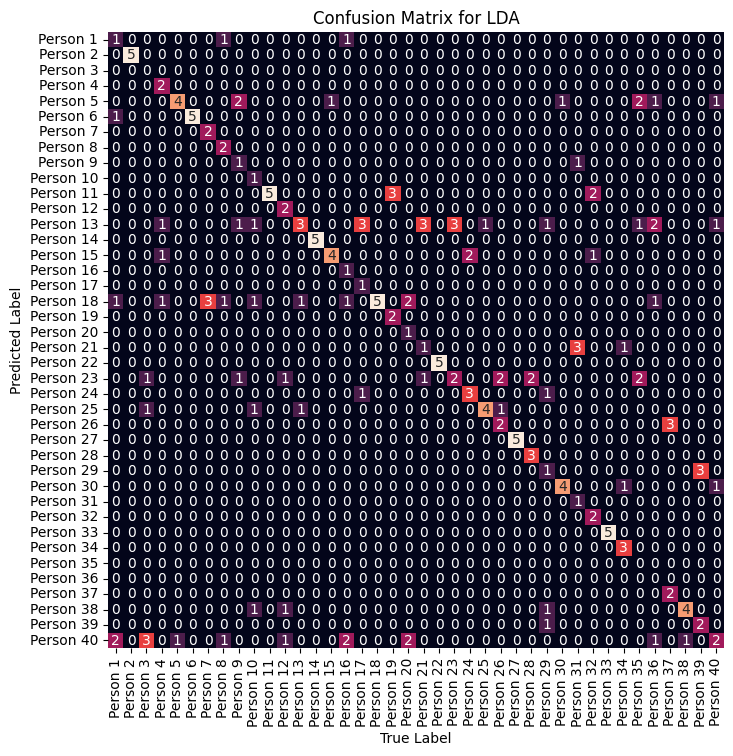


Scenario: 50% training, 50% testing
LDA Accuracy: 81.50%
Confusion Matrix for LDA:
 [[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 2 ... 0 0 2]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]


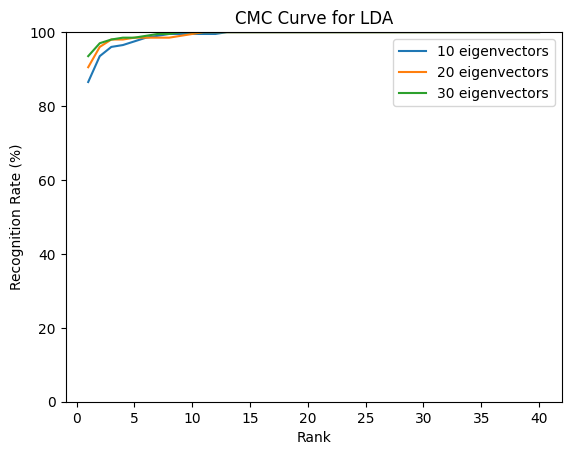

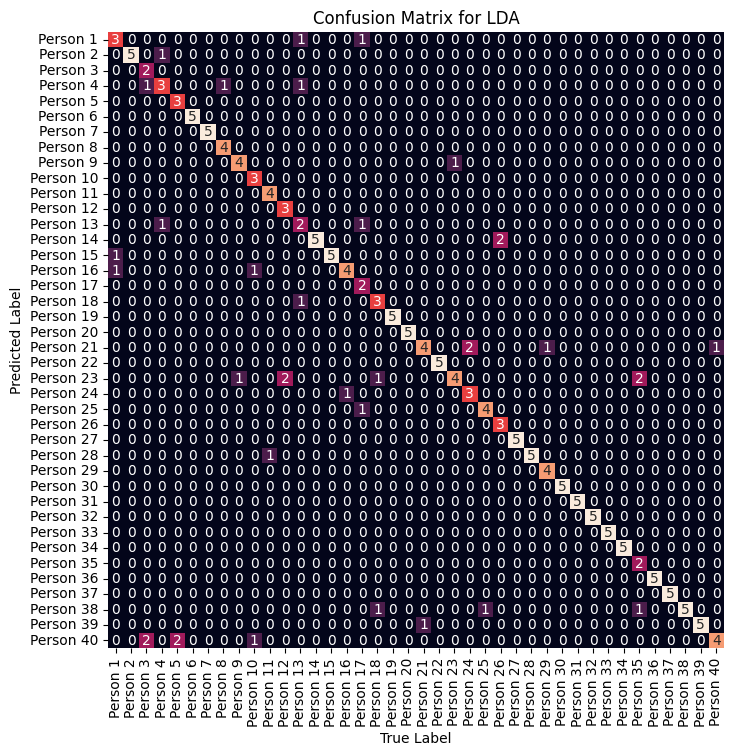


Scenario: 80% training, 20% testing
LDA Accuracy: 88.00%
Confusion Matrix for LDA:
 [[3 0 0 ... 1 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]


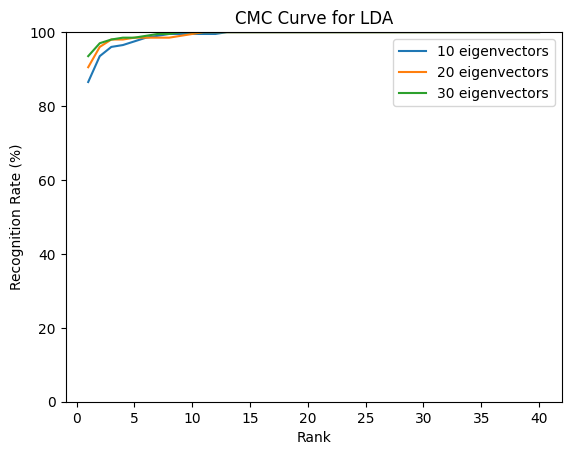

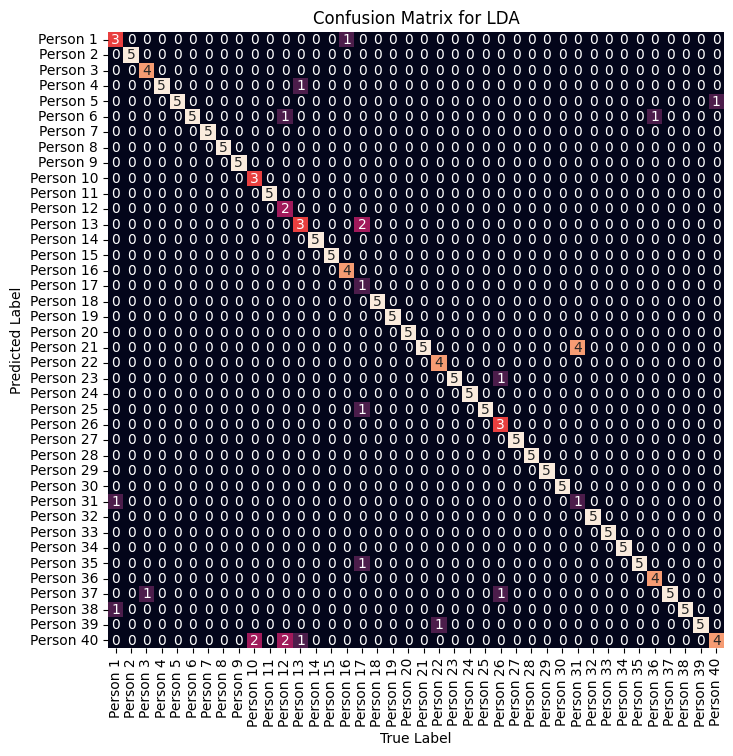

In [ ]:
lda_eval_scenarios(x_train, y_train, x_test, y_test)

**SVM**

In [ ]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train, y_train)

yfit = model.predict_proba(x_test)

print(yfit.shape)

(200, 40)


In [ ]:
# SVM
def SVM_fn(X_train, y_train, X_test, y_test, C=1.0):
  # instance of SVM
  svm = SVC(kernel='linear', C=C)

  # fit SVM on training set
  svm.fit(X_train, y_train)

  # predictions on test set
  predictions = svm.predict(X_test)

  # accuracy
  accuracy = accuracy_score(y_test, predictions)

  # confusion matrix
  confusion_mat = confusion_matrix(y_test, predictions)

  return accuracy, confusion_mat, predictions

In [ ]:
# retrieve accuracy and confusion matrix for SVM and print them
svm_accuracy, svm_confusion_matrix, predictions = SVM_fn(x_train, y_train, x_test, y_test)
print(f"SVM Accuracy: {svm_accuracy:.2%}\n")
print("Confusion Matrix:\n", svm_confusion_matrix)

SVM Accuracy: 90.50%

Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 2 ... 0 0 2]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [1 0 0 ... 0 0 4]]


In [ ]:
def svm_eval_scenarios(X_train, y_train, X_test, y_test):
  # check if training set is empty
  if len(X_train) == 0:
    print("This evaluation has an empty training set.")
    return

  # evaluation scenarios
  scenarios = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]

  # iterate through scenarios
  for train_ratio, test_ratio in scenarios:
    # dataset train/test split
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
      X_train, y_train, train_size=train_ratio, test_size=test_ratio, stratify=y_train,
      random_state=42
    )

    print(f"\nScenario: {int(train_ratio * 100)}% training, {int(test_ratio * 100)}% testing")

    # instance of SVM
    svm = SVC(kernel='linear', C=1.0)

    # fit SVM on the training set
    svm.fit(x_train_split, y_train_split)

    # prediction on test set
    svm_y_pred = svm.predict(X_test)

    # calculate accuracy
    svm_accuracy = accuracy_score(y_test, svm_y_pred)
    print(f"SVM Accuracy: {svm_accuracy:.2%}")

    # confusion matrix
    svm_confusion_mat = confusion_matrix(y_test, svm_y_pred)
    print("Confusion Matrix for SVM:\n", svm_confusion_mat)

    # CMC Curve ----------------------------------------------------------------
    yfit = svm.decision_function(X_test)
    assert len(yfit) == len(y_test)
    CMC = {}
    for i in range(len(yfit)):
      genuine_sim = yfit[i][y_test[i]]
      rank = 1
      for j, sim in enumerate(yfit[i]):
        if j != y_test[i]:
          if sim >= genuine_sim:
            rank += 1
      # save rank
      if rank not in CMC:
        CMC[rank] = 1
      else:
        CMC[rank] += 1

    N = []
    rankN = []
    total = 0
    for i in range(1, len(yfit[0]) + 1):
      if i in CMC:
        total += CMC[i]
      N.append(i)
      rankN.append(100.0 * total / len(yfit))

    plt.title("CMC Curve for SVM")
    plt.plot(N, rankN)
    plt.plot()

    unique_labels = np.unique(faces.target)

    person_names = [f"Person {label + 1}" for label in unique_labels]

    confusion_mat = confusion_matrix(y_test, svm_y_pred)

    # plot the confusion matrix ------------------------------------------------
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels=person_names, yticklabels=person_names)
    plt.title("Confusion Matrix for SVM")
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()


Scenario: 20% training, 80% testing
SVM Accuracy: 51.50%
Confusion Matrix for SVM:
 [[1 0 0 ... 0 0 2]
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 ...
 [0 0 0 ... 4 0 1]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


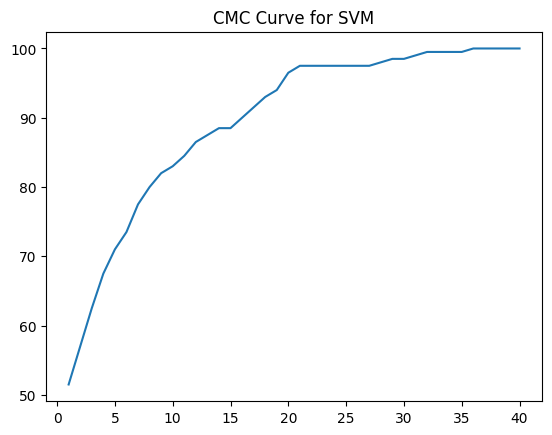

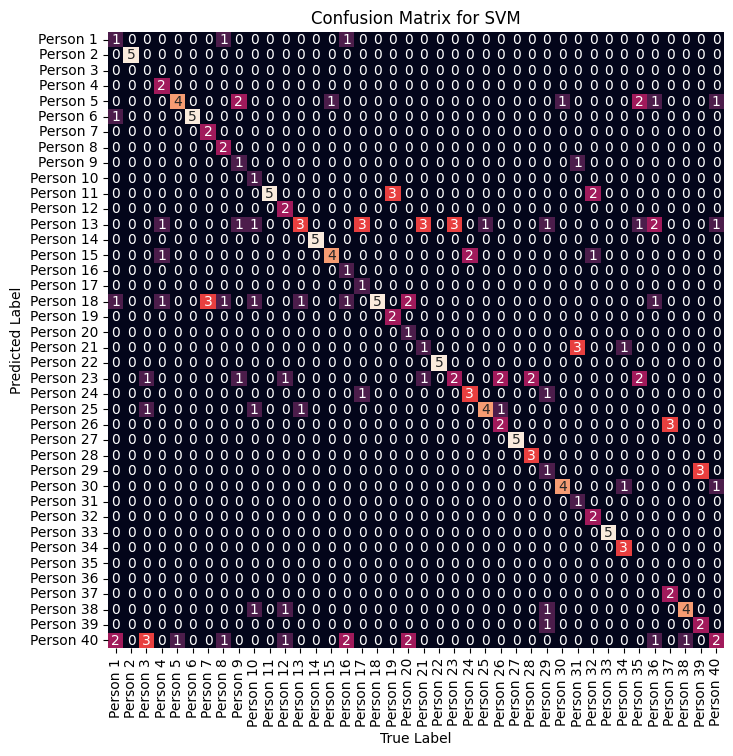


Scenario: 50% training, 50% testing
SVM Accuracy: 79.00%
Confusion Matrix for SVM:
 [[4 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 1 0 2]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [1 0 0 ... 0 0 2]]


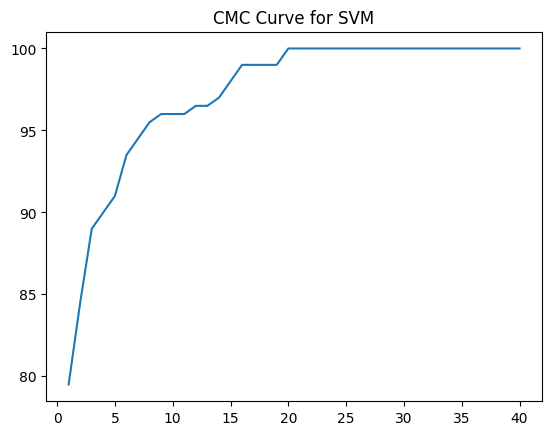

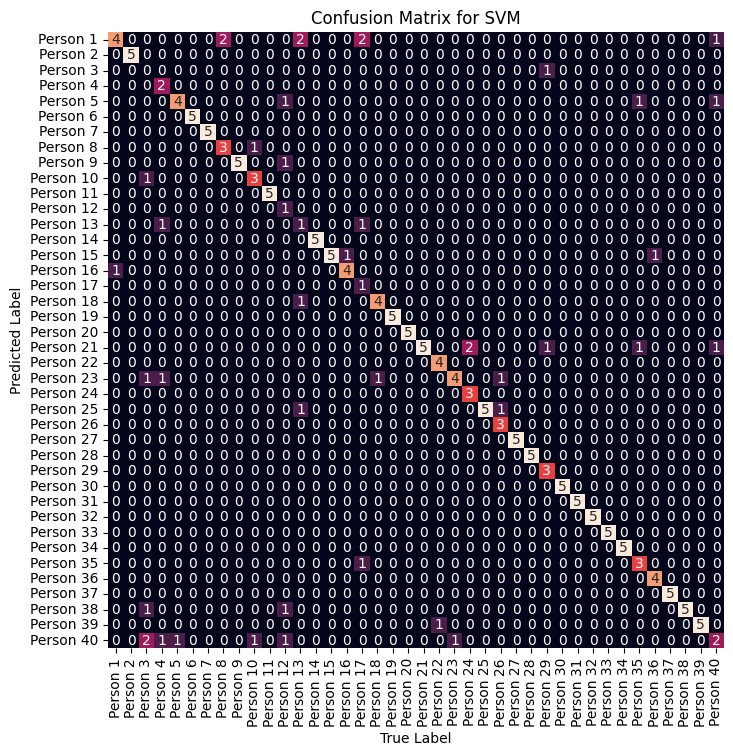


Scenario: 80% training, 20% testing
SVM Accuracy: 85.00%
Confusion Matrix for SVM:
 [[4 0 0 ... 0 0 1]
 [0 5 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]


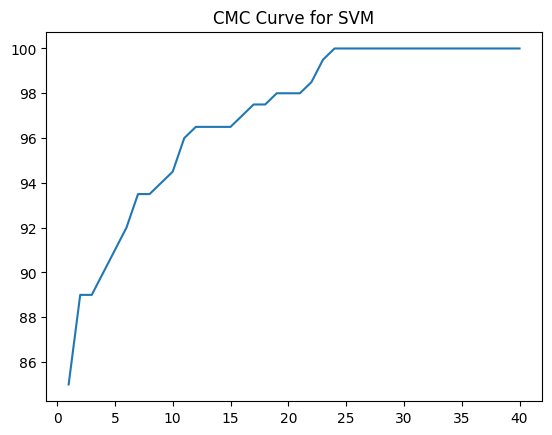

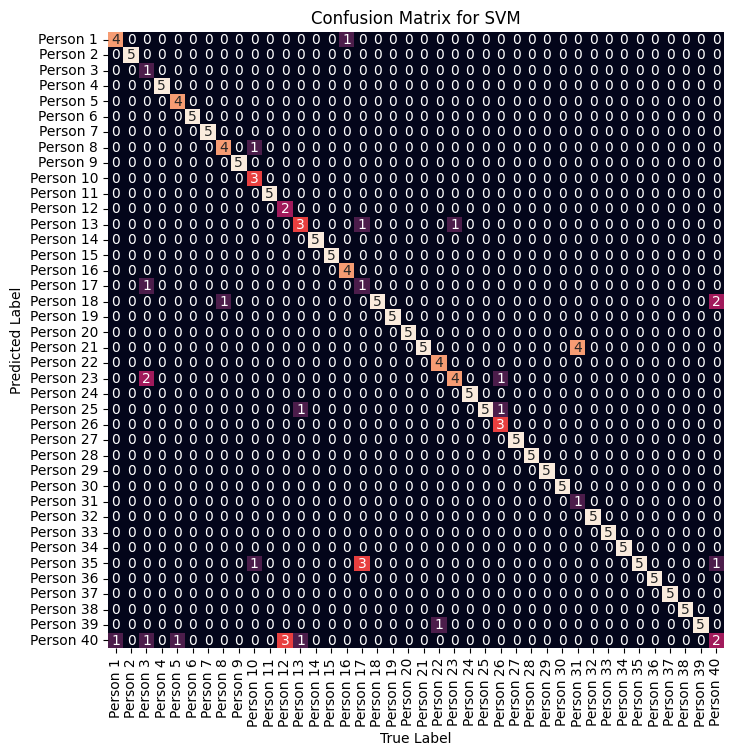

In [ ]:
svm_eval_scenarios(x_train, y_train, x_test, y_test)

# Report your results

Check these amazing plots I have below!

**PCA**

---


Evaluation Scenario: 20% training, 80% testing;
PCA Accuracy: 48.50%

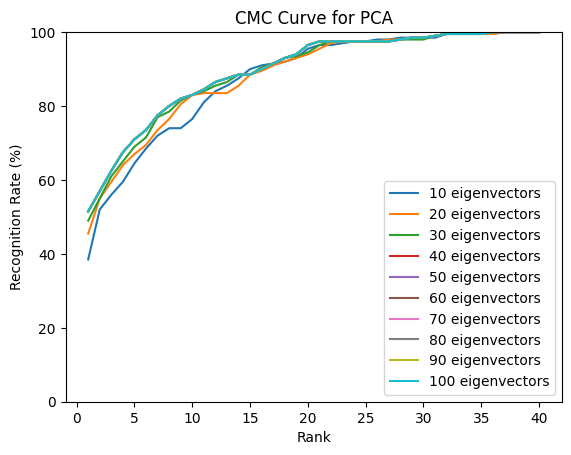

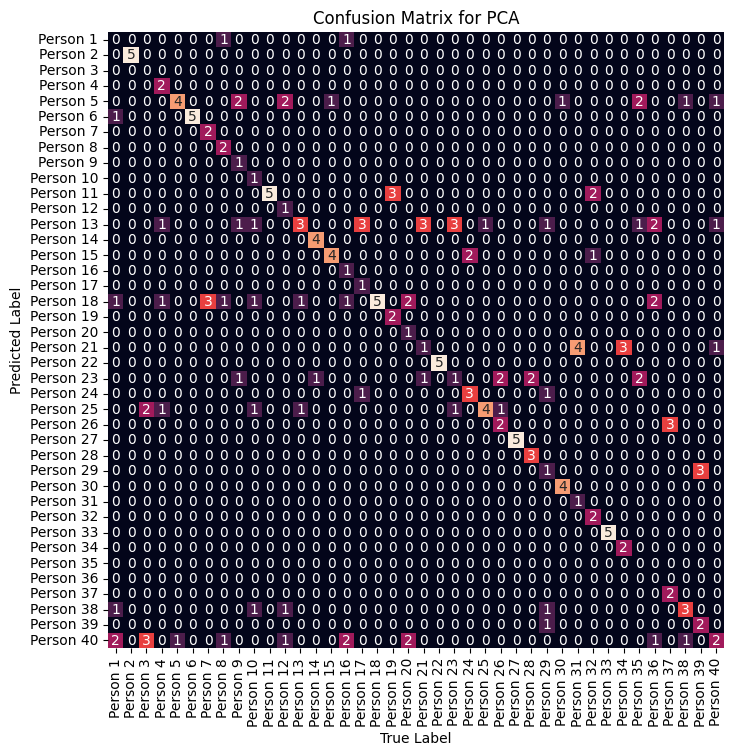

Evaluation Scenario: 50% training, 50% testing; PCA Accuracy: 78.50%

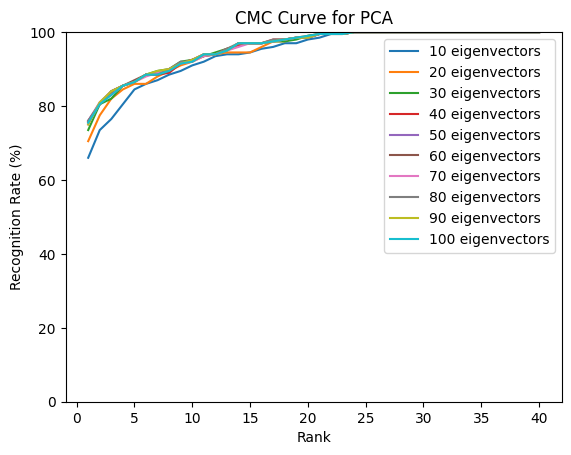

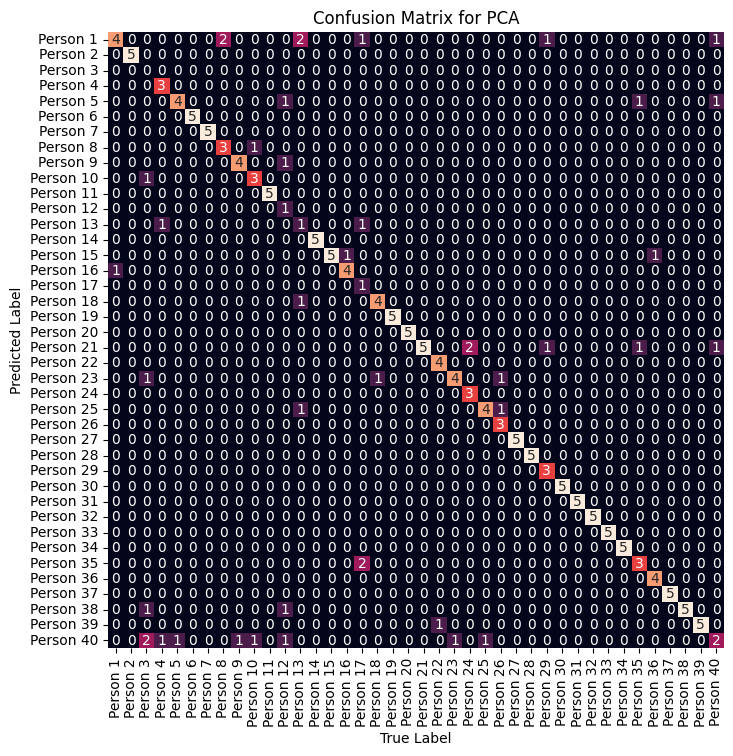

Evaluation Scenario: 80% training, 20% testing; PCA Accuracy: 85.00%

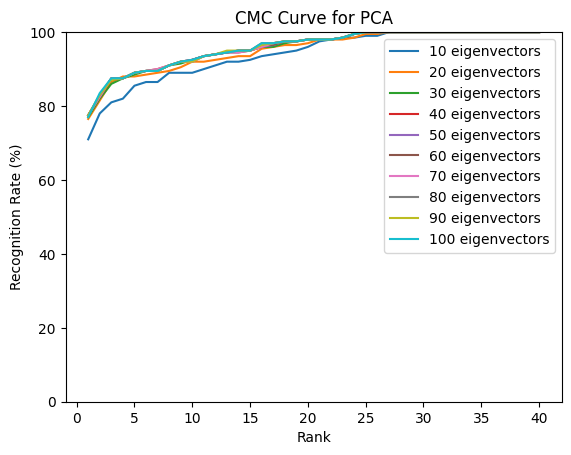

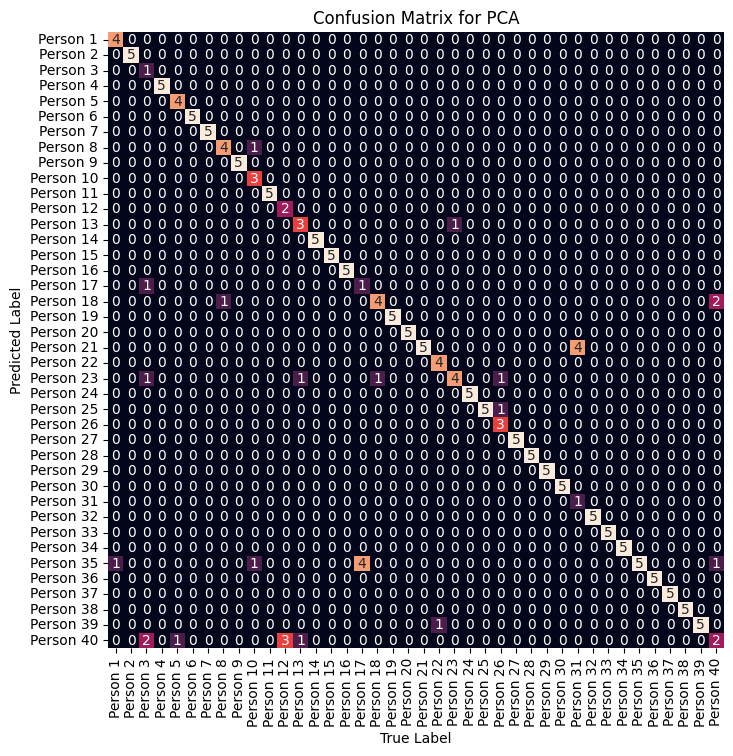

**LDA**


---


Evaluation Scenario: 20% training, 80% testing; LDA Accuracy: 51.50%

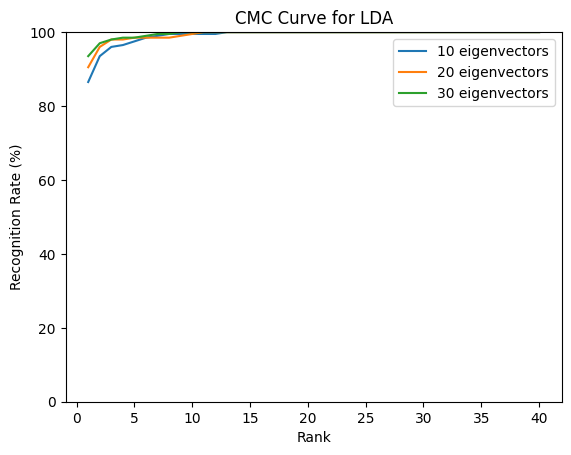

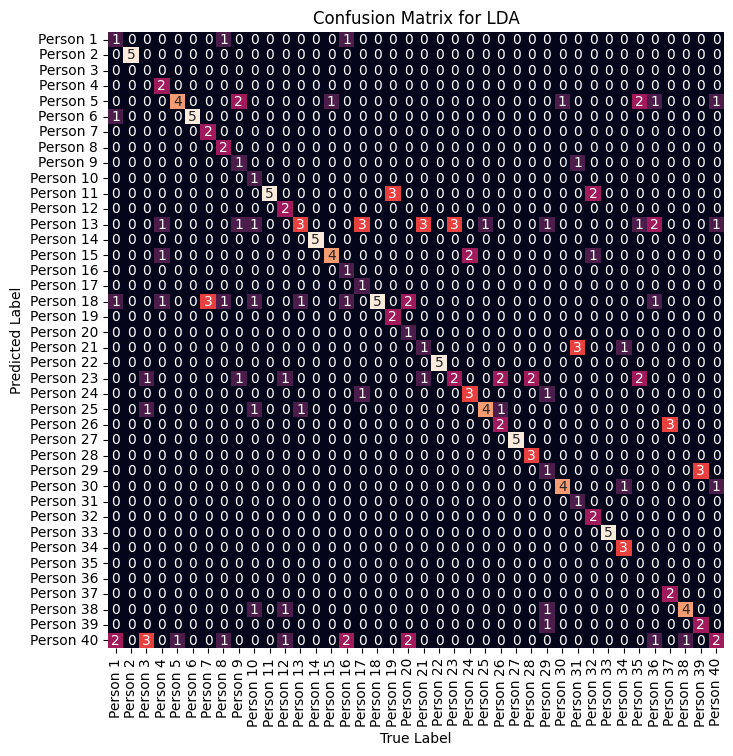

Evaluation Scenario: 50% training, 50% testing; LDA Accuracy: 81.50%

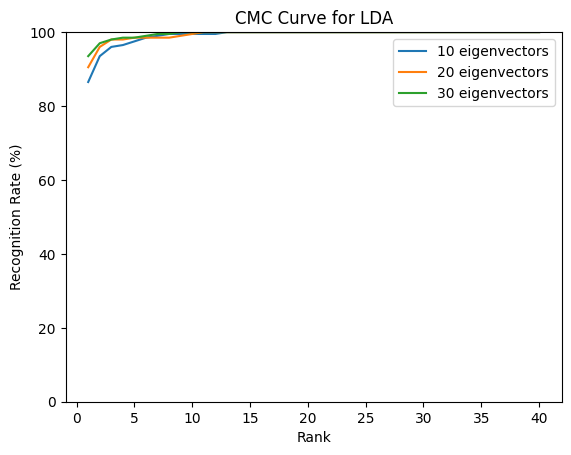

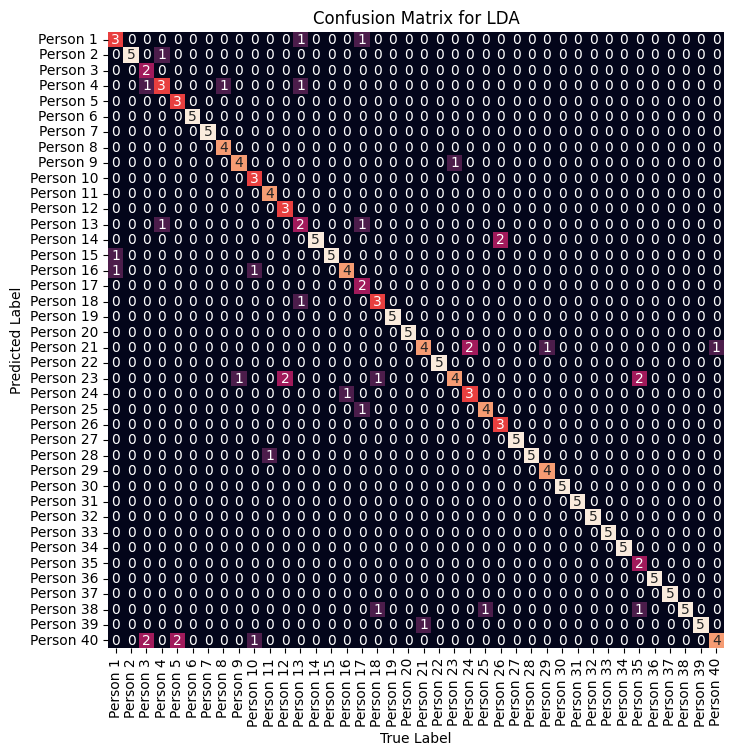

Evaluation Scenario: 80% training, 20% testing; LDA Accuracy: 88.00%

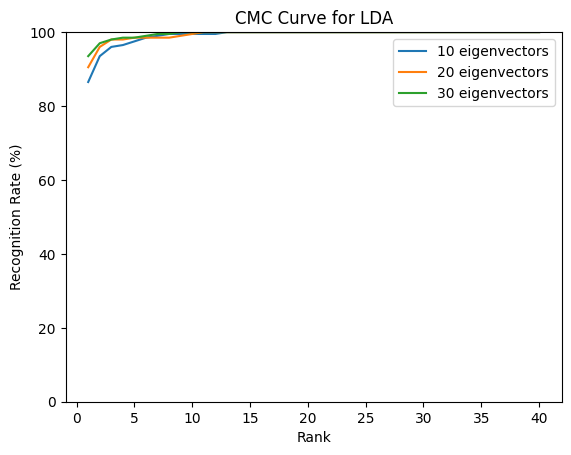

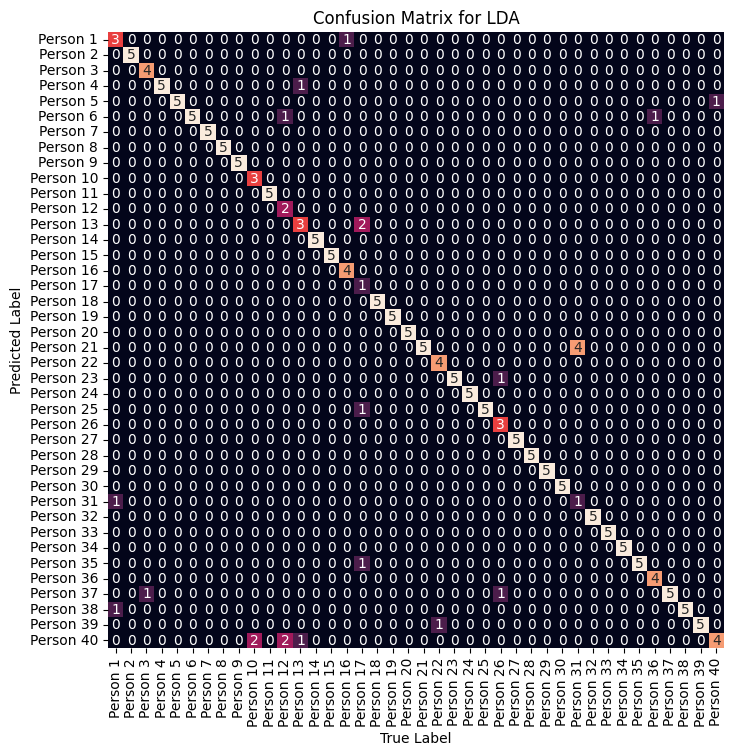

**SVM**


---


Evaluation Scenario: 20% training, 80% testing; SVM Accuracy: 51.50%

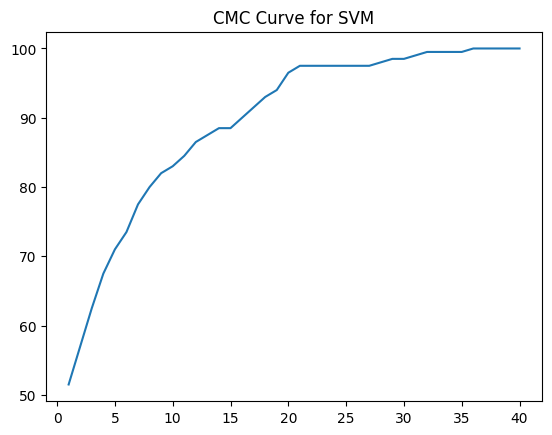

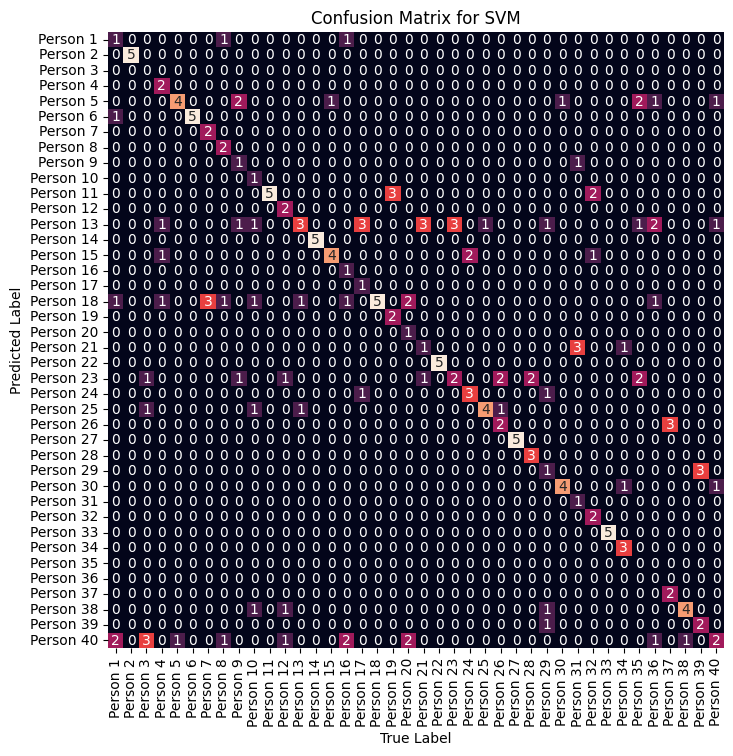

Evaluation Scenario: 50% training, 50% testing; SVM Accuracy: 79.00%

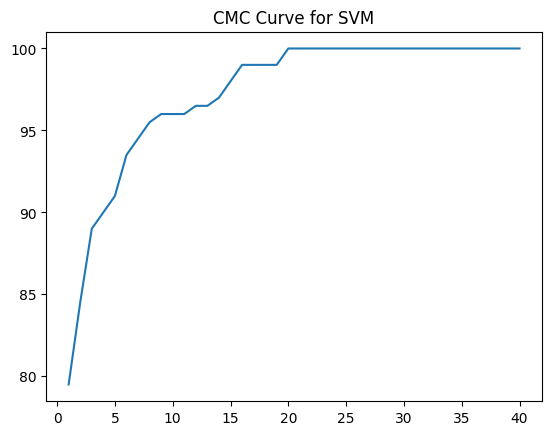

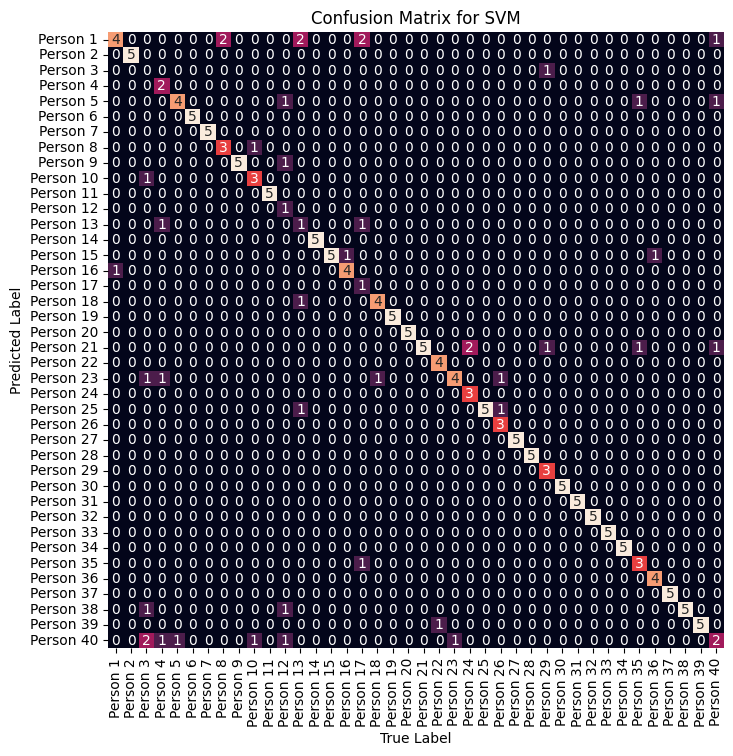

Evaluation Scenario: 80% training, 20% testing; SVM Accuracy: 85.00%

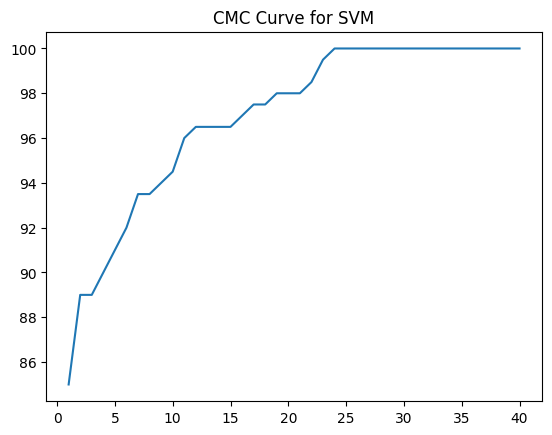

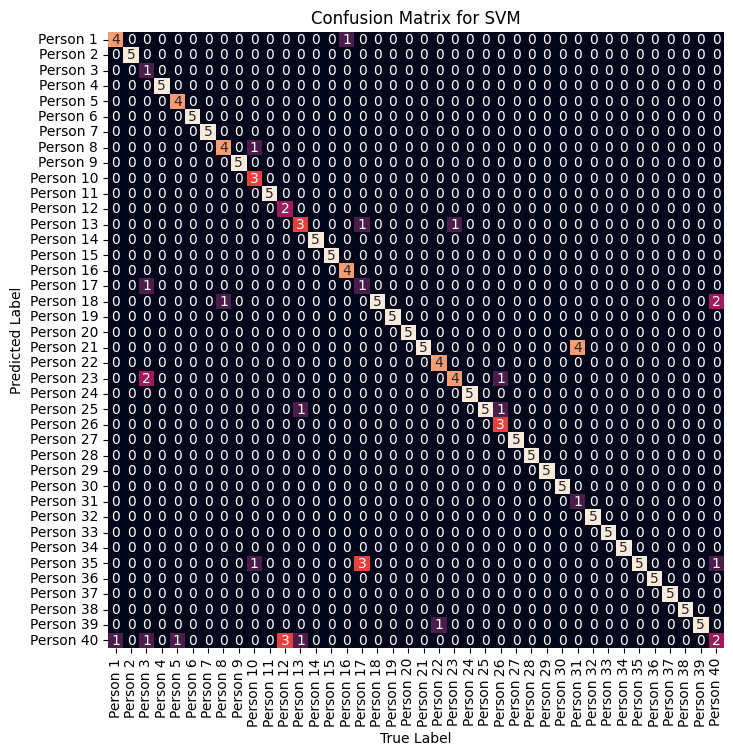

**Baseline**


---


Evaluation Scenario: 20% training, 80% testing; Baseline Accuracy: 51.50%

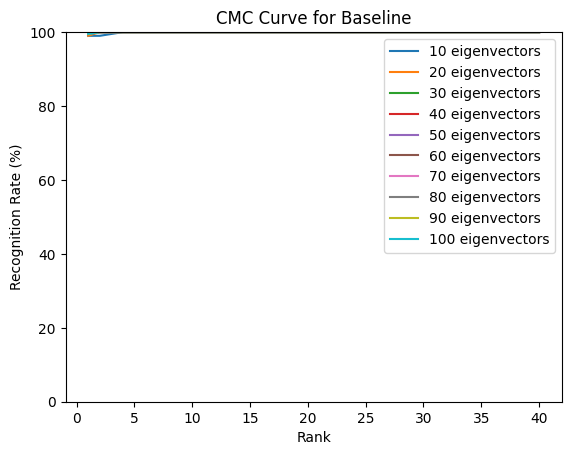

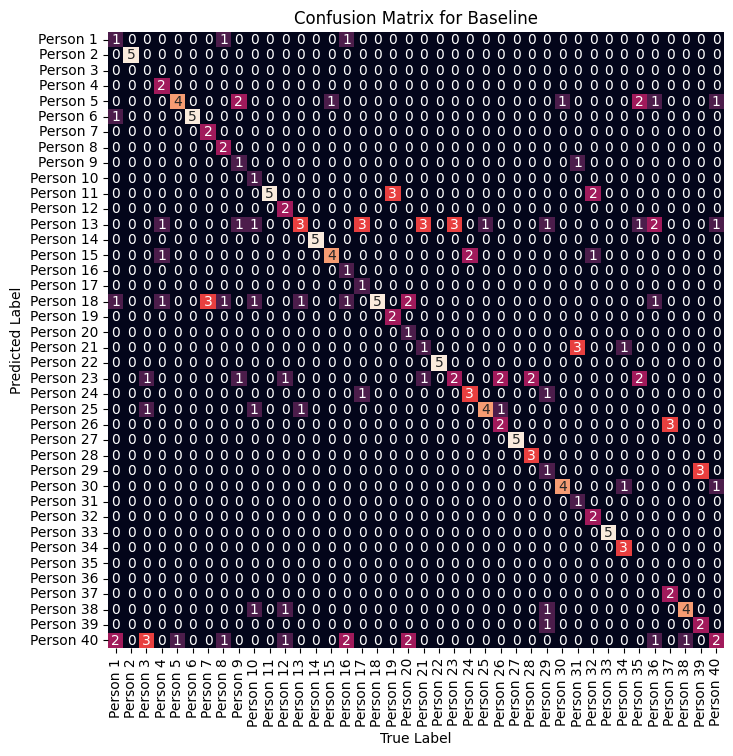

Evaluation Scenario: 50% training, 50% testing; Baseline Accuracy: 9.50%

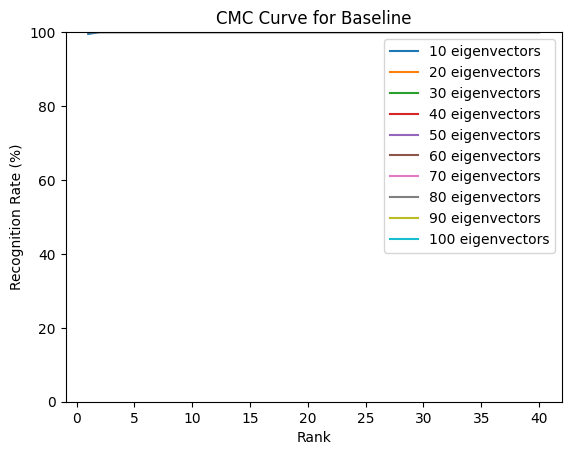

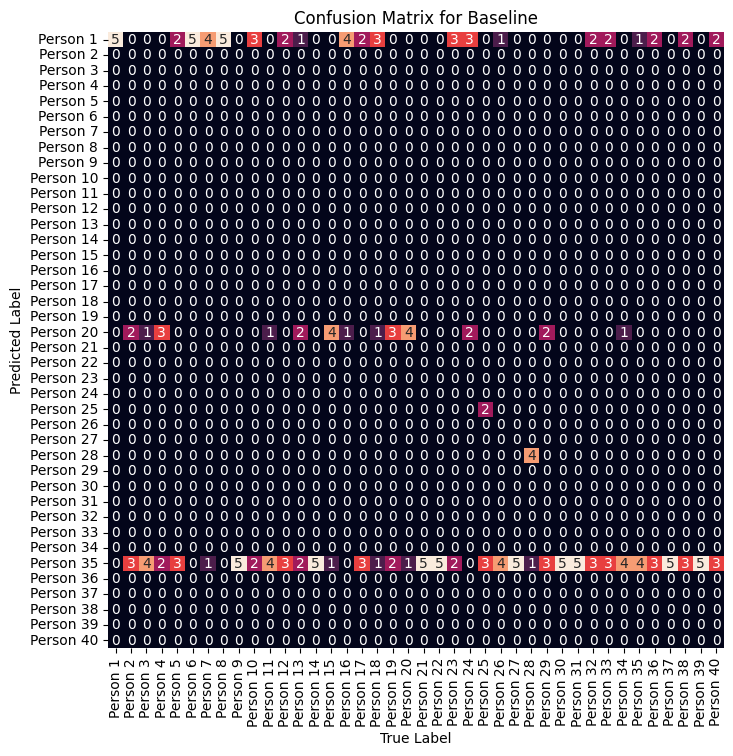

Evaluation Scenario: 80% training, 20% testing; Baseline Accuracy: 55.50%

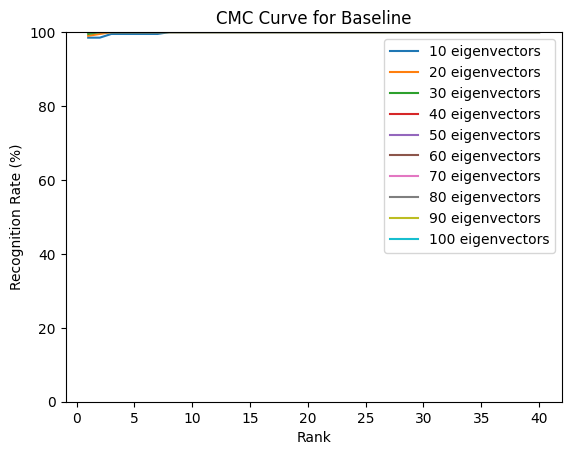

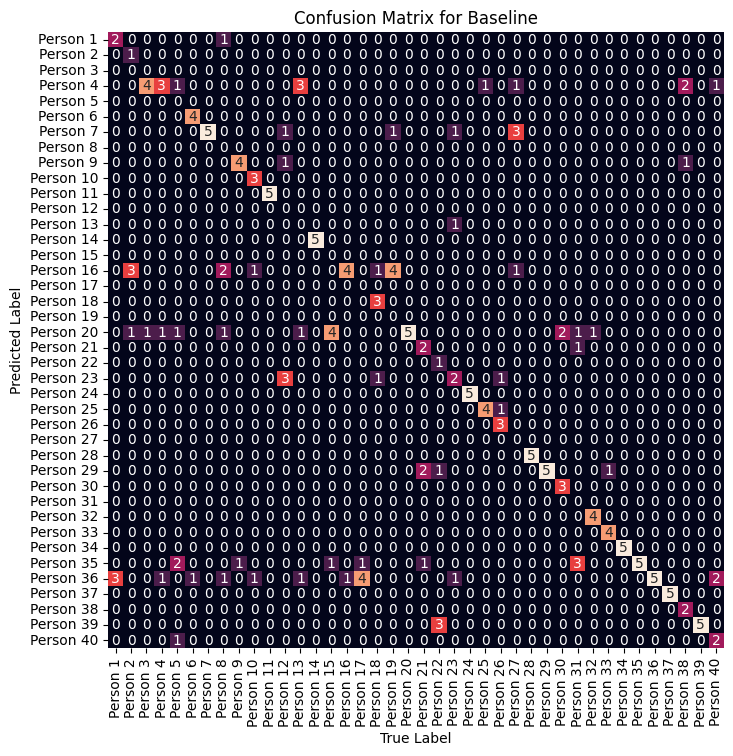

**Discussion**


---


With the Olivetti faces dataset, I implemented a simple Gaussian Naive Bayes baseline, Prinicipal Component Analysis (PCA), Linear Discriminant Analysis (LDA), and Support Vector Machines (SVM). These methods were used in different evaluation scenarios, which modified the percentages of images for training and testing. These scenarios consisted of using 20% of the images for training and 80% for testing, 50% for training and 50% for testing, and 80% for training and 20% for testing. The different methods had varying results, which are displayed on Confusion Matrices and Cumulative Matching Characteristic curves (CMC). These methods for result visualization were useful to look at, as they present the effectiveness of the method in specific scenarios.

For the baseline evaluation, it was a simple method to implement, and it is particularly useful for an initial baseline. It is also common to use when there's a new task. In the evaluation scenarios, it showcases a reasonable accuracy for most scenarios, excluding 50% for training and 50% for testing, where it demonstrates a very low accuracy percentage. In contrast, PCA, LDA, and SVMs performed much better compared to this train/test data split.

As for PCA, it was applied for dimensionality reduction, while retaining 95% of the variance in the data. I utilized linear SVM classifiers to train the PCA-transformed data. With this, I evaluated it in different scenarios, showcasing accuracy percentages of 48.50%, 78.50%, and 85.00% for scenarios with 20%, 50%, and 80% training data, respectively. From this, we can conclude that PCA's accuracy was highly sensitive to the size of the training set. As the training set became larger, the accuracy improved.

With LDA, I also applied it for dimensionality reduction. SVM classifiers were trained on the LDA-transformed data as well. I evaluated it in different scenarios. For the different scenarios [(1) 20% training data, 80% testing data, (2) 50% training data, 50% testing data, (3) 80% training data, 20% testing data], LDA performed with the accuracies 51.50%, 81.50%, 88.00%, respectively. Each of these percentages are higher compared to PCA, making it more accurate despite the different splits. It better captures discriminative features in facial recognition. However, this does not make LDA the most optimal option in every scenario, as LDA consists of computational complexities.

Lastly, with SVM, I trained and evaluated in the different scenarios like the other methods. For the different scenarios [(1) 20% training data, 80% testing data, (2) 50% training data, 50% testing data, (3) 80% training data, 20% testing data], SVM performed with the accuracies 51.50%, 79.00%, 85.00%, respectively. Each of these percentages are higher than or equal to PCA's corresponding accuracies but lower than LDA's. Therefore, it is more accurate than my implementation for PCA, but it is less accurate than LDA's. There could be more analysis done to better understand and utilize these results.

I did not utilize a held-out set, as we were provided with a sufficient-sized dataset accessible. With our task, I tried to assess the models with different train/test data splits. This choice significantly affected my final results. My baseline implementation had varying accuracies among the scenarios, with a low accuracy in the 50% training and 50% testing scenario. Because I didn't incorporate a held-out set, I was able to point out the impact of different train/test splits on the model performance.

There is a clear difference in performance for different approaches. PCA, LDA, and SVMs consistently performed better than my baseline implementation. Also, LDA demonstrated higher accuracies than the rest of the methods.

There is a clear difference in performance for different train/test data splits as well. As the training set size increased, the accuracies of PCA, LDA, and SVMs increased as well, making them sensitive to the size of the training data. As stated previously, the baseline method, on the other hand, had a low accuracy in the 50% training and 50% testing scenario. Overall, the splits impact the results.



